# Libraries

In [14]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from pathlib import Path
import sys

root = str(Path().resolve().parent)
if root not in sys.path:
    sys.path.append(root)
print(*sys.path, sep="\n")

# %matplotlib ipympl
%matplotlib inline

/usr/lib/python312.zip
/usr/lib/python3.12
/usr/lib/python3.12/lib-dynload

/home/ryanwtsai/repos/rfdsp_sim/python/venv/lib/python3.12/site-packages
/home/ryanwtsai/repos/rfdsp_sim/python


In [21]:
from importlib import reload
from rfdsppy import calc, ofdm, rf_analog, rf_tx_fw, tonegen, digital_filter_design, rf_rx_dfe, digital_operations as digops

reload(calc)
reload(ofdm)
reload(rf_analog)
reload(rf_tx_fw)
reload(tonegen)
reload(digital_filter_design)
reload(rf_rx_dfe)
reload(digops)

<module 'rfdsppy.digital_operations' from '/home/ryanwtsai/repos/rfdsp_sim/python/rfdsppy/digital_operations.py'>

# Downsampling

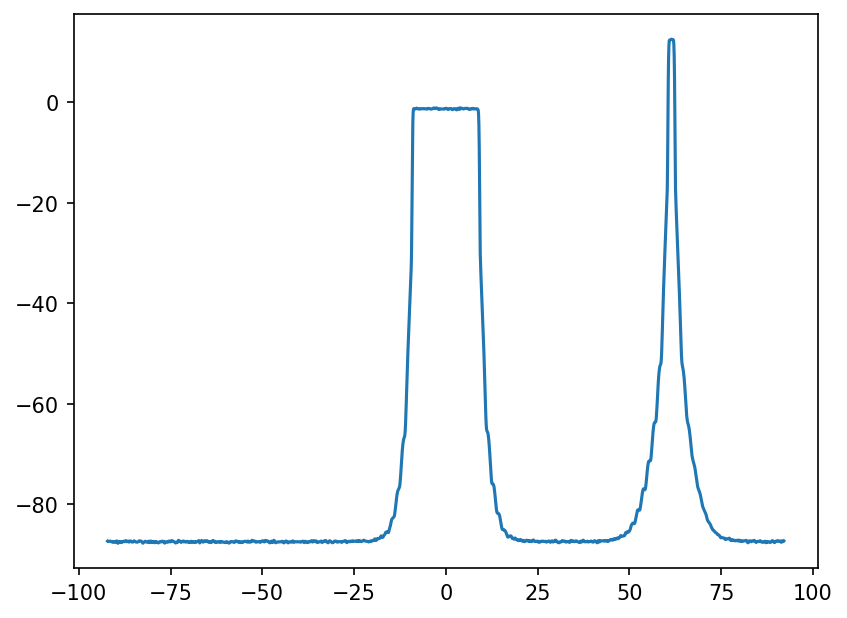

In [16]:
# Generate waveforms

R = 3 # Downsample by 3
pdelta = 3 # Power delta in dB for downsampling example (blocker minus desired)

# Desired signal
nsym = 14*10
modorder = 4
bw = 20
scs = 15
num_sc = 1200
start_sc = 600-round(num_sc/2)
en_tprecode = False
osr = R*2
wola = 1
sig_frac_bits = 15
sig_power = -19
sig_wg = ofdm.OFDMWavGen(bw, scs, modorder, start_sc, num_sc=num_sc, en_tprecode=en_tprecode, osr=osr, wola=wola, bitwidth=sig_frac_bits+1, power=sig_power)

x_signal, x_standard = sig_wg.generate(nsym)
cfg = sig_wg.get_demod_params()
fs_in = cfg.get("fs")

# Blocker
num_sc_block = 100
start_sc_block = round((100*12-num_sc_block)/2)
block_wg = ofdm.OFDMWavGen(bw, scs, modorder, start_sc_block, num_sc=num_sc_block, en_tprecode=en_tprecode, osr=osr, wola=wola, bitwidth=sig_frac_bits+1, power=sig_power+pdelta)
x_blocker, _ = block_wg.generate(nsym)
w_blocker = 2*np.pi/R
x_blocker = x_blocker*np.exp(1j*w_blocker*np.arange(x_blocker.size)) # Frequency shift blocker to correct location

# Add signal and blocker
x = x_signal+x_blocker

p, f = calc.psd(x, fs_in, fs_in/2048)
fig, axs = plt.subplots(dpi=150)
axs.plot(f, 10*np.log10(p))

digital_filter_design.firls_rate_change()
Largest passband ripple (dB) = 0.0
Smallest stopband rejection (dB) = 123.9





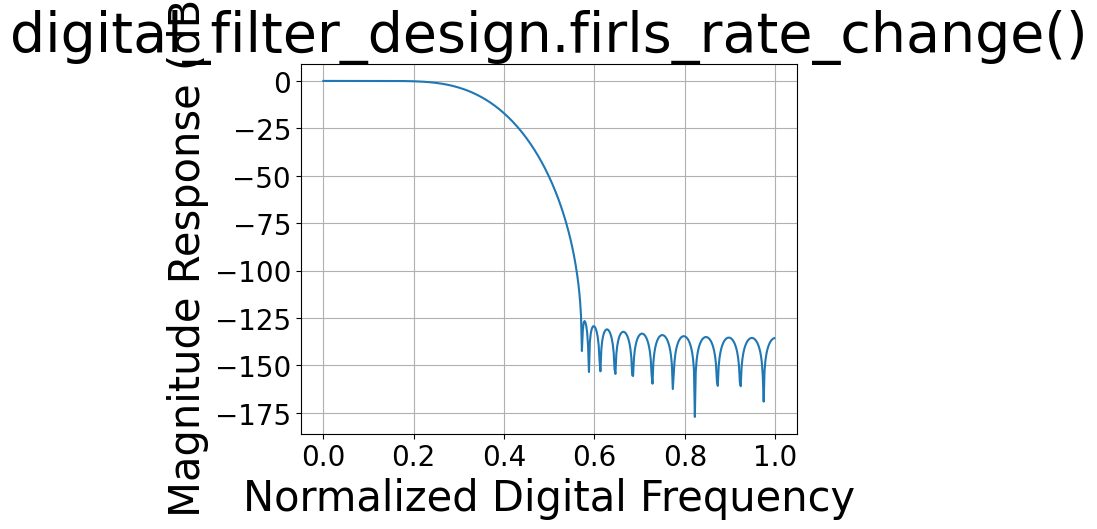

In [17]:
ntaps = 31
obw = num_sc*scs/1000
b = digital_filter_design.firls_rate_change('down', ntaps, obw, fs_in, R, en_plot=True)
frac_bits = 0
frac_bits = 15
b = (b*2**frac_bits).round()
b = b.astype(int)

np.float64(36718919793910.55)

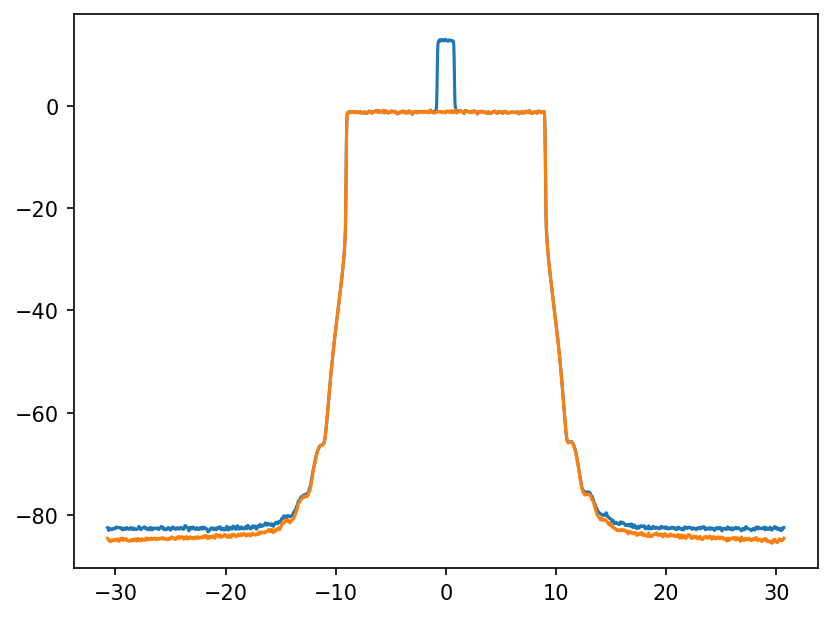

In [ ]:
# Filter using the prototype filter
y_prototype = signal.lfilter(b, 1, x)
if frac_bits > 0:
    y_prototype = (y_prototype/2**frac_bits).round()
y_prototype_down = digops.downsample(y_prototype, R)
# y_prototype_down = digops.downsample(x, R) # no filtering

# Filter using the polyphase filter
y_polyphase = rf_rx_dfe.polyphase_downsampler(x, b, R, frac_bits)

fig, axs = plt.subplots(dpi=150)

p, f = calc.psd(y_prototype_down, fs_in/R, fs_in/R/2048)
axs.plot(f,10*np.log10(p))

p, f = calc.psd(y_polyphase, fs_in/R, fs_in/R/2048)
axs.plot(f,10*np.log10(p))

min_len = np.min((y_polyphase.size, y_prototype_down.size))
e = y_polyphase[:min_len]-y_prototype_down[:min_len]
np.vdot(e, e).real